In [1]:
import torch
from torchvision.transforms import Normalize

from model.model import BackboneType, MultiNet
from torchvision.io import read_image, ImageReadMode, write_png
from torchvision.transforms.functional import resize, InterpolationMode
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from utils.utils import combine_channels
import cv2


def generate_ctr(output_tensor: torch.Tensor):
    output_tensor = torch.clone(output_tensor).cpu()


def generate_visualization(outputs: torch.Tensor):
    colors = torch.tensor(
        [
            [0, 0, 0],
            [0, 0, 128],
            [128, 64, 128],
        ],
        dtype=torch.uint8,
    )
    predicted_image = combine_channels(outputs[0], colors, True)
    predicted_image = predicted_image[..., [2, 1, 0]].permute([2, 0, 1]).cpu()
    return predicted_image

In [2]:
if torch.backends.mps.is_available():
    print("Using MPS engine")
    device = "mps"
elif torch.cuda.is_available():
    print("Using CUDA engine")
    device = "cuda"
else:
    print("Using CPU engine")
    device = "cpu"

model = MultiNet(numberClass=3, backboneType=BackboneType.RESNET50)
preprocessor = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

# Load weights into model
model.load_state_dict(
    torch.load(
        "data/model/cardiac_model_new.pt",
        map_location=device,
    )
)

# Load image
file_path = "data/cardiac/chestxray/images_001/images/00000005_000.png"
file_path2 = "data/cardiac/chestxray/images_001/images/00000002_000.png"
image = read_image(file_path, ImageReadMode.RGB)
image2 = read_image(file_path2, ImageReadMode.RGB)
batch_image = torch.stack([(image / 255), (image2 / 255)])

model.eval()
with torch.no_grad():
    original_image = resize(batch_image, [512, 512], interpolation=InterpolationMode.NEAREST)
    image = preprocessor(original_image)
    output_tensor = model(image)
    visualization_tensor = generate_visualization(output_tensor)
    write_png(visualization_tensor, "visualization.png")

Using MPS engine


0.4216
0.4688


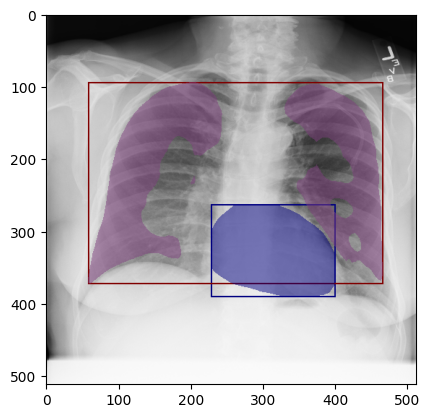

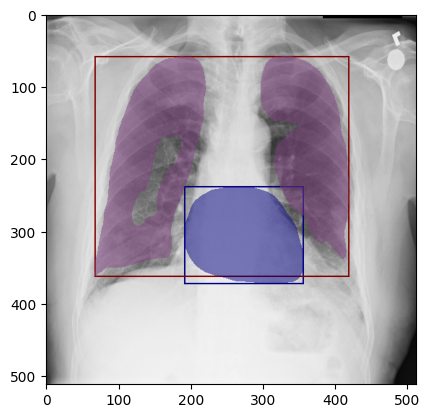

In [11]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(output_tensor.size(0)):
    heart_mask = output_tensor[i].sigmoid().permute([1, 2, 0])[..., 2].to(torch.uint8)
    heart_mask = cv2.dilate(heart_mask.numpy(), np.ones([5, 5]), iterations=5)

    x, y, w, h = cv2.boundingRect(heart_mask)
    image_bounding_box = draw_bounding_boxes(
        (original_image[i] * 255).to(torch.uint8),
        torch.tensor([[x, y, x + w, y + h]]),
        colors=(0, 0, 128),
        width=2,
    )
    heart_width = w

    lung_mask = output_tensor[i].sigmoid().permute([1, 2, 0])[..., 1].to(torch.uint8)
    x, y, w, h = cv2.boundingRect(lung_mask.numpy())
    image_bounding_box = draw_bounding_boxes(
        image_bounding_box,
        torch.tensor([[x, y, x + w, y + h]]),
        colors=(128, 0, 0),
        width=2,
    )
    lung_width = w

    image_bounding_box = draw_segmentation_masks(
        image_bounding_box,
        torch.Tensor(heart_mask) > 0.5,
        alpha=0.5,
        colors=(0, 0, 128),
    )
    image_bounding_box = draw_segmentation_masks(
        image_bounding_box,
        lung_mask > 0.5,
        alpha=0.5,
        colors=(128, 64, 128),
    )

    plt.figure()
    plt.imshow(image_bounding_box.permute([1, 2, 0]))
    print(f"{(heart_width / lung_width):.4f}")